In [40]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt

## NICE MODEL

### Coupling Layer

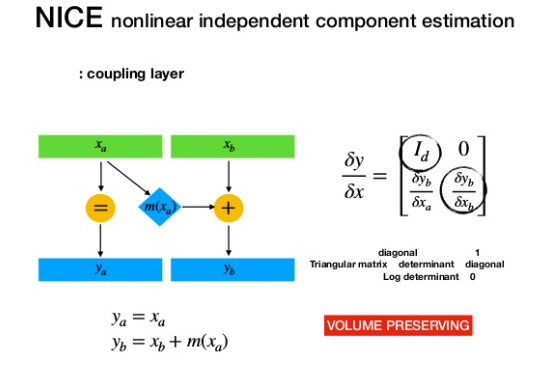

In [2]:
"""Additive coupling layer.
"""
class Coupling(nn.Module):
    def __init__(self, in_out_dim, mid_dim, hidden, mask_config):
        """Initialize a coupling layer.
        Args:
            in_out_dim: input/output dimensions.
            mid_dim: number of units in a hidden layer.
            hidden: number of hidden layers.
            mask_config: 1 if transform odd units, 0 if transform even units.
        """
        super(Coupling, self).__init__()
        self.mask_config = mask_config

        self.in_block = nn.Sequential(
            nn.Linear(in_out_dim//2, mid_dim),
            nn.ReLU())
        self.mid_block = nn.ModuleList([
            nn.Sequential(
                nn.Linear(mid_dim, mid_dim),
                nn.ReLU()) for _ in range(hidden - 1)])
        self.out_block = nn.Linear(mid_dim, in_out_dim//2)

    def forward(self, x, reverse=False):
        """Forward pass.
        Args:
            x: input tensor.
            reverse: True in inference mode, False in sampling mode.
        Returns:
            transformed tensor.
        """
                
        ### PPT에서는 1:d  / d+1 : N 에 따라 나눴지만
        ### 코드는 홀수 짝수로 나눔
        ### 이 부분 아래 참조
        
        [B, W] = list(x.size())
        x = x.reshape((B, W//2, 2))
        
        ### mask_config 1 
        ## 짝수 index -> identity mapping (PPT a 부분)
        ## 홀수 index -> neural Net 통과 (PPT b 부분)
        
        if self.mask_config:
            on, off = x[:, :, 0], x[:, :, 1]
        else:
            off, on = x[:, :, 0], x[:, :, 1]

        off_ = self.in_block(off)
        for i in range(len(self.mid_block)):
            off_ = self.mid_block[i](off_)
        shift = self.out_block(off_)
        
        if reverse:
            on = on - shift
        else:
            on = on + shift

        if self.mask_config:
            x = torch.stack((on, off), dim=2)
        else:
            x = torch.stack((off, on), dim=2)
        return x.reshape((B, W))

* list(x.size())
*  x = x.reshape((B, W//2, 2))

In [3]:
import numpy as np
tmp = [i for i in range(20)]
tmp = np.array(tmp)
tmp

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [4]:
### 짝수 홀수 인덱스로 나뉜다
tmp.reshape(1,10,2)

array([[[ 0,  1],
        [ 2,  3],
        [ 4,  5],
        [ 6,  7],
        [ 8,  9],
        [10, 11],
        [12, 13],
        [14, 15],
        [16, 17],
        [18, 19]]])

### Scaling Layer

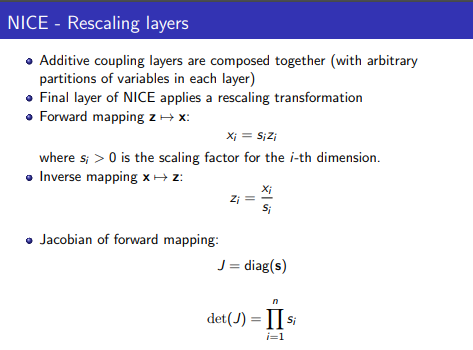

In [18]:
'''
    Log Scaling

'''

class Scaling(nn.Module):
    def __init__(self, dim):
        """Initialize a (log-)scaling layer.
        Args:
            dim: input/output dimensions.
        """
        super(Scaling, self).__init__()
        self.scale = nn.Parameter(
            torch.zeros((1, dim)), requires_grad=True)

    def forward(self, x, reverse=False):
        """Forward pass.
        Args:
            x: input tensor.
            reverse: True in inference mode, False in sampling mode.
        Returns:
            transformed tensor and log-determinant of Jacobian.
        """
        log_det_J = torch.sum(self.scale)
        if reverse:
            x = x * torch.exp(-self.scale)
        else:
            x = x * torch.exp(self.scale)
        return x, log_det_J

### Nice Model

In [19]:
"""NICE main model.
"""
class NICE(nn.Module):
    def __init__(self, prior, coupling, 
        in_out_dim, mid_dim, hidden, mask_config):
        """Initialize a NICE.
        Args:
            prior: prior distribution over latent space Z.
            coupling: number of coupling layers.
            in_out_dim: input/output dimensions.
            mid_dim: number of units in a hidden layer.
            hidden: number of hidden layers.
            mask_config: 1 if transform odd units, 0 if transform even units.
        """
        super(NICE, self).__init__()
        self.prior = prior
        self.in_out_dim = in_out_dim

        self.coupling = nn.ModuleList([
            Coupling(in_out_dim=in_out_dim, 
                     mid_dim=mid_dim, 
                     hidden=hidden, 
                     mask_config=(mask_config+i)%2) \
            for i in range(coupling)])
        self.scaling = Scaling(in_out_dim)

    def g(self, z):
        """Transformation g: Z -> X (inverse of f).
        Args:
            z: tensor in latent space Z.
        Returns:
            transformed tensor in data space X.
        """
        x, _ = self.scaling(z, reverse=True)
        for i in reversed(range(len(self.coupling))):
            x = self.coupling[i](x, reverse=True)
        return x

    def f(self, x):
        """Transformation f: X -> Z (inverse of g).
        Args:
            x: tensor in data space X.
        Returns:
            transformed tensor in latent space Z.
        """
        for i in range(len(self.coupling)):
            x = self.coupling[i](x)
        return self.scaling(x)

    def log_prob(self, x):
        """Computes data log-likelihood.
        (See Section 3.3 in the NICE paper.)
        Args:
            x: input minibatch.
        Returns:
            log-likelihood of input.
        """
        z, log_det_J = self.f(x)
        log_ll = torch.sum(self.prior.log_prob(z), dim=1)
        return log_ll + log_det_J

    def sample(self, size):
        """Generates samples.
        Args:
            size: number of samples to generate.
        Returns:
            samples from the data space X.
        """
        z = self.prior.sample((size, self.in_out_dim)).cuda()
        return self.g(z)

    def forward(self, x):
        """Forward pass.
        Args:
            x: input minibatch.
        Returns:
            log-likelihood of input.
        """
        return self.log_prob(x)

## Training

In [20]:
## utils

import torch
import torch.nn.functional as F

def dequantize(x, dataset):
    '''Dequantize data.
    Add noise sampled from Uniform(0, 1) to each pixel (in [0, 255]).
    Args:
        x: input tensor.
        reverse: True in inference mode, False in training mode.
    Returns:
        dequantized data.
    '''
    noise = torch.distributions.Uniform(0., 1.).sample(x.size())
    return (x * 255. + noise) / 256.

def prepare_data(x, dataset, zca=None, mean=None, reverse=False):
    """Prepares data for NICE.
    In training mode, flatten and dequantize the input.
    In inference mode, reshape tensor into image size.
    Args:
        x: input minibatch.
        dataset: name of dataset.
        zca: ZCA whitening transformation matrix.
        mean: center of original dataset.
        reverse: True if in inference mode, False if in training mode.
    Returns:
        transformed data.
    """
    if reverse:
        assert len(list(x.size())) == 2
        [B, W] = list(x.size())

        if dataset in ['mnist', 'fashion-mnist']:
            assert W == 1 * 28 * 28
            x += mean
            x = x.reshape((B, 1, 28, 28))
        elif dataset in ['svhn', 'cifar10']:
            assert W == 3 * 32 * 32
            x = torch.matmul(x, zca.inverse()) + mean
            x = x.reshape((B, 3, 32, 32))
    else:
        assert len(list(x.size())) == 4
        [B, C, H, W] = list(x.size())

        if dataset in ['mnist', 'fashion-mnist']:
            assert [C, H, W] == [1, 28, 28]
        elif dataset in ['svhn', 'cifar10']:
            assert [C, H, W] == [3, 32, 32]

        x = dequantize(x, dataset)
        x = x.reshape((B, C*H*W))

        if dataset in ['mnist', 'fashion-mnist']:
            x -= mean
        elif dataset in ['svhn', 'cifar10']:
            x = torch.matmul((x - mean), zca)
    return x

"""Standard logistic distribution.
"""
class StandardLogistic(torch.distributions.Distribution):
    def __init__(self):
        super(StandardLogistic, self).__init__()

    def log_prob(self, x):
        """Computes data log-likelihood.
        Args:
            x: input tensor.
        Returns:
            log-likelihood.
        """
        return -(F.softplus(x) + F.softplus(-x))

    def sample(self, size):
        """Samples from the distribution.
        Args:
            size: number of samples to generate.
        Returns:
            samples.
        """
        z = torch.distributions.Uniform(0., 1.).sample(size).cuda()
        return torch.log(z) - torch.log(1. - z)

In [24]:
device = torch.device("cuda:0")

# model hyperparameters
dataset = 'mnist'
batch_size = 200
latent = 'logistic'
max_iter = 10000
sample_size = 64
coupling = 4
mask_config = 1.

# optimization hyperparameters
lr = 0.001
momentum = 0.9
decay = 0.999

zca = None
mean = None

In [25]:
if dataset == 'mnist':
    mean = torch.load('./statistics/mnist_mean.pt')
    (full_dim, mid_dim, hidden) = (1 * 28 * 28, 1000, 5)
    transform = torchvision.transforms.ToTensor()
    trainset = torchvision.datasets.MNIST(root='../MNIST',
        train=True, download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset,
        batch_size=batch_size, shuffle=True, num_workers=2)

In [26]:
if latent == 'normal':
    prior = torch.distributions.Normal(
        torch.tensor(0.).to(device), torch.tensor(1.).to(device))
elif latent == 'logistic':
    prior = StandardLogistic()

filename = '%s_' % dataset \
         + 'bs%d_' % batch_size \
         + '%s_' % latent \
         + 'cp%d_' % coupling \
         + 'md%d_' % mid_dim \
         + 'hd%d_' % hidden

flow = NICE(prior=prior, 
            coupling=coupling, 
            in_out_dim=full_dim, 
            mid_dim=mid_dim, 
            hidden=hidden, 
            mask_config=mask_config).to(device)

optimizer = torch.optim.Adam(
    flow.parameters(), lr=lr, betas=(momentum, decay), eps=1e-4)

total_iter = 0
train = True
running_loss = 0

while train:
    for _, data in enumerate(trainloader, 1):
        flow.train()    # set to training mode
        if total_iter == max_iter:
            train = False
            break

        total_iter += 1
        optimizer.zero_grad()    # clear gradient tensors

        inputs, _ = data
        inputs = prepare_data(
            inputs, dataset, zca=zca, mean=mean).to(device)

        # log-likelihood of input minibatch
        loss = -flow(inputs).mean()
        running_loss += float(loss)

        # backprop and update parameters
        loss.backward()
        optimizer.step()

        if total_iter % 1000 == 0:
            mean_loss = running_loss / 1000
            bit_per_dim = (mean_loss + np.log(256.) * full_dim) \
                        / (full_dim * np.log(2.))
            print('iter %s:' % total_iter, 
                'loss = %.3f' % mean_loss, 
                'bits/dim = %.3f' % bit_per_dim)
            running_loss = 0.0


print('Finished training!')

iter 1000: loss = 703.963 bits/dim = 9.295
iter 2000: loss = -37.494 bits/dim = 7.931
iter 3000: loss = -654.513 bits/dim = 6.796
iter 4000: loss = -1113.343 bits/dim = 5.951
iter 5000: loss = -1453.703 bits/dim = 5.325
iter 6000: loss = -1708.093 bits/dim = 4.857
iter 7000: loss = -1881.421 bits/dim = 4.538
iter 8000: loss = -1964.785 bits/dim = 4.384
iter 9000: loss = -2004.243 bits/dim = 4.312
iter 10000: loss = -2025.879 bits/dim = 4.272
Finished training!


## Inference

In [74]:

flow.eval()        # set to inference mode
with torch.no_grad():
    z, _ = flow.f(inputs)
    reconst = flow.g(z).cpu()
    reconst = prepare_data(
        reconst, dataset, zca=zca, mean=mean, reverse=True)
    samples = flow.sample(sample_size).cpu()
    samples = prepare_data(
        samples, dataset, zca=zca, mean=mean, reverse=True)

    ## show Image
    grid_img_recon =torchvision.utils.make_grid(reconst)
    
    torchvision.utils.save_image(torchvision.utils.make_grid(reconst),
        './' + filename +'sample_iter%d.png' % total_iter)
    
    grid_img_sample =torchvision.utils.make_grid(samples)
    torchvision.utils.save_image(torchvision.utils.make_grid(samples),
        './' + filename +'reconstruct_iter%d.png' % total_iter)


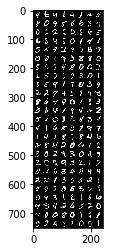

In [75]:
plt.imshow(grid_img_recon.permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


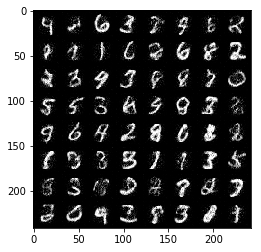

In [76]:
plt.imshow(grid_img_sample.permute(1,2,0))